## 📑 Table of Contents

0. **Install Dependencies** — Install required Python packages.
1. **Imports & Global Settings** — Import libraries, set seeds, define paths.
2. **Split Train/Val** — Create 80/20 train/validation split if missing.
3. **Fix Dataset YAML Paths** — Adjust dataset YAML file paths for Kaggle.
4. **Plot DFL Loss Curve Utility** — Function to plot DFL loss during training.
5. **Train YOLO Model** — Main training function with early stopping.
6. **Predict on Sample Images** — Visualize predictions on random samples.
7. **Prepare Dataset** — Validate dataset structure and create YAML if missing.
8. **Main Execution** — Prepare dataset, train model, and run sample predictions.
9. **Plot YOLO Training Curves** — Plot Box/Cls/DFL loss and metrics from results.csv.
10. **Save Artifacts** — Save trained weights, results, and plots for reuse.

### 📄 Project Overview
This notebook trains and evaluates a YOLOv8n object detection model to locate bacterial flagellar motors in cryo-electron tomograms (BYU 2025 competition).  
The workflow covers:
- Preparing the dataset (including automatic 80/20 train/val split).
- Fixing dataset YAML paths for Kaggle compatibility.
- Training YOLOv8n with early stopping and logging.
- Visualizing losses and validation metrics.
- Running inference on sample images for quick inspection.
- Saving trained weights and artifacts.
- Performing inference on the test set and generating `submission.csv` for competition submission.


In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

byu_locating_bacterial_flagellar_motors_2025_path = kagglehub.competition_download('byu-locating-bacterial-flagellar-motors-2025')
andrewjdarley_parse_data_path = kagglehub.notebook_output_download('andrewjdarley/parse-data')

print('Data source import complete.')


# SECTION 0 — Install dependency


In [ ]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.3 MB/s eta 0:00:0000:01


# SECTION 1 — Imports & global settings


In [ ]:
import os
import torch
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from ultralytics import YOLO
import yaml
import pandas as pd
import json

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Define paths for Kaggle environment
yolo_dataset_dir = "/kaggle/input/parse-data/yolo_dataset"
yolo_weights_dir = "/kaggle/working/yolo_weights"
yolo_pretrained_weights = "yolov8n.pt"  # Path to pre-downloaded weights

# Create weights directory if it doesn't exist
os.makedirs(yolo_weights_dir, exist_ok=True)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# SECTION 2 — Split train into train/val


In [ ]:
from pathlib import Path
import random
import shutil

# אחוז מהאימון שישמש כולידציה
val_percentage = 0.2

# נתיבים
train_images_dir = Path("/kaggle/input/parse-data/yolo_dataset/images/train")
train_labels_dir = Path("/kaggle/input/parse-data/yolo_dataset/labels/train")
val_images_dir   = Path("/kaggle/input/parse-data/yolo_dataset/images/val")
val_labels_dir   = Path("/kaggle/input/parse-data/yolo_dataset/labels/val")

# יצירת תיקיות אם לא קיימות
val_images_dir.mkdir(parents=True, exist_ok=True)
val_labels_dir.mkdir(parents=True, exist_ok=True)

# אם אין עדיין ולידציה – צור אותה
if len(list(val_images_dir.glob("*"))) == 0:
    train_images = list(train_images_dir.glob("*.jpg")) + list(train_images_dir.glob("*.png"))
    val_count = int(len(train_images) * val_percentage)
    val_set = set(random.sample(train_images, val_count))

    for img_path in train_images:
        label_path = train_labels_dir / (img_path.stem + ".txt")
        if img_path in val_set:
            shutil.move(str(img_path), str(val_images_dir / img_path.name))
            if label_path.exists():
                shutil.move(str(label_path), str(val_labels_dir / label_path.name))

    print(f"Validation split complete: {val_count} images moved to val set")
else:
    print("Validation set already exists — skipping split.")


Validation set already exists — skipping split.


# SECTION 3 — Utility: fix dataset YAML path


In [ ]:
def fix_yaml_paths(yaml_path):
    """
    Fix the paths in the YAML file to match the actual Kaggle directories

    Args:
        yaml_path (str): Path to the original dataset YAML file

    Returns:
        str: Path to the fixed YAML file
    """
    print(f"Fixing YAML paths in {yaml_path}")

    # Read the original YAML
    with open(yaml_path, 'r') as f:
        yaml_data = yaml.safe_load(f)

    # Update paths to use actual dataset location
    if 'path' in yaml_data:
        yaml_data['path'] = yolo_dataset_dir

    # Create a new fixed YAML in the working directory
    fixed_yaml_path = "/kaggle/working/fixed_dataset.yaml"
    with open(fixed_yaml_path, 'w') as f:
        yaml.dump(yaml_data, f)

    print(f"Created fixed YAML at {fixed_yaml_path} with path: {yaml_data.get('path')}")
    return fixed_yaml_path


# SECTION 4 — Utility: plot DFL loss curve from run


In [ ]:
def plot_dfl_loss_curve(run_dir):
    """
    Plot the DFL loss curves for train and validation, marking the best model

    Args:
        run_dir (str): Directory where the training results are stored
    """
    # Path to the results CSV file
    results_csv = os.path.join(run_dir, 'results.csv')

    if not os.path.exists(results_csv):
        print(f"Results file not found at {results_csv}")
        return

    # Read results CSV
    results_df = pd.read_csv(results_csv)

    # Check if DFL loss columns exist
    train_dfl_col = [col for col in results_df.columns if 'train/dfl_loss' in col]
    val_dfl_col = [col for col in results_df.columns if 'val/dfl_loss' in col]

    if not train_dfl_col or not val_dfl_col:
        print("DFL loss columns not found in results CSV")
        print(f"Available columns: {results_df.columns.tolist()}")
        return

    train_dfl_col = train_dfl_col[0]
    val_dfl_col = val_dfl_col[0]

    # Find the epoch with the best validation loss
    best_epoch = results_df[val_dfl_col].idxmin()
    best_val_loss = results_df.loc[best_epoch, val_dfl_col]

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot training and validation losses
    plt.plot(results_df['epoch'], results_df[train_dfl_col], label='Train DFL Loss')
    plt.plot(results_df['epoch'], results_df[val_dfl_col], label='Validation DFL Loss')

    # Mark the best model with a vertical line
    plt.axvline(x=results_df.loc[best_epoch, 'epoch'], color='r', linestyle='--',
                label=f'Best Model (Epoch {int(results_df.loc[best_epoch, "epoch"])}, Val Loss: {best_val_loss:.4f})')

    # Add labels and legend
    plt.xlabel('Epoch')
    plt.ylabel('DFL Loss')
    plt.title('Training and Validation DFL Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Save the plot in the same directory as weights
    plot_path = os.path.join(run_dir, 'dfl_loss_curve.png')
    plt.savefig(plot_path)

    # Also save it to the working directory for easier access
    plt.savefig(os.path.join('/kaggle/working', 'dfl_loss_curve.png'))

    print(f"Loss curve saved to {plot_path}")
    plt.close()

    # Return the best epoch info
    return best_epoch, best_val_loss

# SECTION 5 — Train YOLO model (main trainer)


In [ ]:
def train_yolo_model(yaml_path, pretrained_weights_path, epochs=30, batch_size=16, img_size=640):
    """
    Train a YOLO model on the prepared dataset

    Args:
        yaml_path (str): Path to the dataset YAML file
        pretrained_weights_path (str): Path to pre-downloaded weights file
        epochs (int): Number of training epochs
        batch_size (int): Batch size for training
        img_size (int): Image size for training
    """
    print(f"Loading pre-trained weights from: {pretrained_weights_path}")

    # Load a pre-trained YOLOv8 model
    model = YOLO(pretrained_weights_path)

    # Train the model with early stopping
    results = model.train(
        data=yaml_path,
        epochs=epochs,
        batch=batch_size,
        imgsz=img_size,
        project=yolo_weights_dir,
        name='motor_detector',
        exist_ok=True,
        patience=8,              # Early stopping if no improvement for 5 epochs
        save_period=5,           # Save checkpoints every 5 epochs
        val=True,                # Ensure validation is performed
        verbose=True             # Show detailed output during training
    )

    # Get the path to the run directory
    run_dir = os.path.join(yolo_weights_dir, 'motor_detector')

    # Plot and save the loss curve
    best_epoch_info = plot_dfl_loss_curve(run_dir)

    if best_epoch_info:
        best_epoch, best_val_loss = best_epoch_info
        print(f"\nBest model found at epoch {best_epoch} with validation DFL loss: {best_val_loss:.4f}")

    return model, results


# SECTION 6 — Inference helper on sample images


In [ ]:
def predict_on_samples(model, num_samples=4):
    """
    Run predictions on random validation samples and display results

    Args:
        model: Trained YOLO model
        num_samples (int): Number of random samples to test
    """
    # Get validation images
    val_dir = os.path.join(yolo_dataset_dir, 'images', 'val')
    if not os.path.exists(val_dir):
        print(f"Validation directory not found at {val_dir}")
        # Try train directory instead if val doesn't exist
        val_dir = os.path.join(yolo_dataset_dir, 'images', 'train')
        print(f"Using train directory for predictions instead: {val_dir}")

    if not os.path.exists(val_dir):
        print("No images directory found for predictions")
        return

    val_images = os.listdir(val_dir)

    if len(val_images) == 0:
        print("No images found for prediction")
        return

    # Select random samples
    num_samples = min(num_samples, len(val_images))
    samples = random.sample(val_images, num_samples)

    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()

    for i, img_file in enumerate(samples):
        if i >= len(axes):
            break

        img_path = os.path.join(val_dir, img_file)

        # Run prediction
        results = model.predict(img_path, conf=0.25)[0]

        # Load and display the image
        img = Image.open(img_path)
        axes[i].imshow(np.array(img), cmap='gray')

        # Draw ground truth box if available (from filename)
        try:
            # This assumes your filenames contain coordinates in a specific format
            parts = img_file.split('_')
            y_part = [p for p in parts if p.startswith('y')]
            x_part = [p for p in parts if p.startswith('x')]

            if y_part and x_part:
                y_gt = int(y_part[0][1:])
                x_gt = int(x_part[0][1:].split('.')[0])

                box_size = 24
                rect_gt = Rectangle((x_gt - box_size//2, y_gt - box_size//2),
                              box_size, box_size,
                              linewidth=1, edgecolor='g', facecolor='none')
                axes[i].add_patch(rect_gt)
        except:
            pass  # Skip ground truth if parsing fails

        # Draw predicted boxes (red)
        if len(results.boxes) > 0:
            boxes = results.boxes.xyxy.cpu().numpy()
            confs = results.boxes.conf.cpu().numpy()

            for box, conf in zip(boxes, confs):
                x1, y1, x2, y2 = box
                rect_pred = Rectangle((x1, y1), x2-x1, y2-y1,
                                     linewidth=1, edgecolor='r', facecolor='none')
                axes[i].add_patch(rect_pred)
                axes[i].text(x1, y1-5, f'{conf:.2f}', color='red')

        axes[i].set_title(f"Image: {img_file}\nGround Truth (green) vs Prediction (red)")

    plt.tight_layout()

    # Save the predictions plot
    plt.savefig(os.path.join('/kaggle/working', 'predictions.png'))
    plt.show()


# SECTION 7 — Dataset check & YAML creation (if YAML missing)


In [ ]:
def prepare_dataset():
    """
    Check if dataset exists and create a proper YAML if needed

    Returns:
        str: Path to the YAML file to use for training
    """
    # Check if images exist
    train_images_dir = os.path.join(yolo_dataset_dir, 'images', 'train')
    val_images_dir = os.path.join(yolo_dataset_dir, 'images', 'val')
    train_labels_dir = os.path.join(yolo_dataset_dir, 'labels', 'train')
    val_labels_dir = os.path.join(yolo_dataset_dir, 'labels', 'val')

    # Print directory existence status
    print(f"Directory status:")
    print(f"- Train images dir exists: {os.path.exists(train_images_dir)}")
    print(f"- Val images dir exists: {os.path.exists(val_images_dir)}")
    print(f"- Train labels dir exists: {os.path.exists(train_labels_dir)}")
    print(f"- Val labels dir exists: {os.path.exists(val_labels_dir)}")

    # Check for original YAML file
    original_yaml_path = os.path.join(yolo_dataset_dir, 'dataset.yaml')

    if os.path.exists(original_yaml_path):
        print(f"Found original dataset.yaml at {original_yaml_path}")
        # Fix the paths in the YAML
        return fix_yaml_paths(original_yaml_path)
    else:
        print(f"Original dataset.yaml not found, creating a new one")

        # Create a new YAML file
        yaml_data = {
            'path': yolo_dataset_dir,
            'train': 'images/train',
            'val': 'images/train' if not os.path.exists(val_images_dir) else 'images/val',
            'names': {0: 'motor'}
        }

        new_yaml_path = "/kaggle/working/dataset.yaml"
        with open(new_yaml_path, 'w') as f:
            yaml.dump(yaml_data, f)

        print(f"Created new YAML at {new_yaml_path}")
        return new_yaml_path

# SECTION 8 — Main execution


In [ ]:
def main():
    print("Starting YOLO training process...")

    # Prepare dataset and get YAML path
    yaml_path = prepare_dataset()
    print(f"Using YAML file: {yaml_path}")

    # Print YAML file contents
    with open(yaml_path, 'r') as f:
        yaml_content = f.read()
    print(f"YAML file contents:\n{yaml_content}")

    # Train model
    print("\nStarting YOLO training...")
    model, results = train_yolo_model(
        yaml_path,
        pretrained_weights_path=yolo_pretrained_weights,
        epochs=150  # Using 30 epochs instead of 100 for faster training
    )

    print("\nTraining complete!")

    # Run predictions
    print("\nRunning predictions on sample images...")
    predict_on_samples(model, num_samples=4)

Starting YOLO training process...
Directory status:
- Train images dir exists: True
- Val images dir exists: True
- Train labels dir exists: True
- Val labels dir exists: True
Found original dataset.yaml at /kaggle/input/parse-data/yolo_dataset/dataset.yaml
Fixing YAML paths in /kaggle/input/parse-data/yolo_dataset/dataset.yaml
Created fixed YAML at /kaggle/working/fixed_dataset.yaml with path: /kaggle/input/parse-data/yolo_dataset
Using YAML file: /kaggle/working/fixed_dataset.yaml
YAML file contents:
names:
  0: motor
path: /kaggle/input/parse-data/yolo_dataset
train: images/train
val: images/val


Starting YOLO training...
Loading pre-trained weights from: yolov8n.pt


Ultralytics 8.3.179 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/fixed_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=motor_detector, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=8, perspective=0.0, plots=True, pose=12.

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.1±0.2 ms, read: 44.4±14.6 MB/s, size: 345.6 KB)


train: Scanning /kaggle/input/parse-data/yolo_dataset/labels/train... 3262 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3262/3262 [00:19<00:00, 170.81it/s]


WARNING ⚠️ train: Cache directory /kaggle/input/parse-data/yolo_dataset/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 46.2±20.6 MB/s, size: 365.7 KB)


val: Scanning /kaggle/input/parse-data/yolo_dataset/labels/val... 792 images, 0 backgrounds, 0 corrupt: 100%|██████████| 792/792 [00:04<00:00, 162.43it/s]


WARNING ⚠️ val: Cache directory /kaggle/input/parse-data/yolo_dataset/labels is not writeable, cache not saved.
Plotting labels to /kaggle/working/yolo_weights/motor_detector/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /kaggle/working/yolo_weights/motor_detector
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      2.08G      3.442       11.3      1.332         13        640: 100%|██████████| 204/204 [00:44<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.44it/s]


                   all        792        792      0.212      0.237      0.145     0.0536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      2.79G      2.713      3.474      1.062         22        640: 100%|██████████| 204/204 [00:42<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.47it/s]


                   all        792        792      0.185      0.182     0.0748     0.0119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      2.79G      2.465      2.223      1.018         21        640: 100%|██████████| 204/204 [00:41<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.44it/s]


                   all        792        792      0.443      0.553      0.408      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150       2.8G      2.372      1.921      1.006         17        640: 100%|██████████| 204/204 [00:42<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.65it/s]

                   all        792        792      0.446      0.393      0.335     0.0733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150       2.8G      2.271      1.728     0.9846         19        640: 100%|██████████| 204/204 [00:41<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.62it/s]


                   all        792        792      0.685       0.59      0.595      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150       2.8G      2.167      1.626     0.9626         21        640: 100%|██████████| 204/204 [00:42<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.65it/s]

                   all        792        792      0.486      0.398      0.352     0.0882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150       2.8G      2.096       1.54     0.9503         19        640: 100%|██████████| 204/204 [00:41<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.66it/s]

                   all        792        792      0.644      0.491      0.509       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150       2.8G      2.025      1.442     0.9386         20        640: 100%|██████████| 204/204 [00:42<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.67it/s]


                   all        792        792      0.695      0.688      0.691      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150       2.8G      1.993      1.406     0.9289         13        640: 100%|██████████| 204/204 [00:41<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.60it/s]

                   all        792        792      0.683      0.718       0.72      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150       2.8G      1.968      1.369     0.9245         16        640: 100%|██████████| 204/204 [00:42<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]

                   all        792        792      0.652      0.528      0.532      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150       2.8G      1.897      1.308     0.9161         12        640: 100%|██████████| 204/204 [00:41<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.63it/s]

                   all        792        792      0.557      0.426      0.387     0.0982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150       2.8G      1.895       1.32     0.9109         18        640: 100%|██████████| 204/204 [00:42<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.45it/s]

                   all        792        792      0.793      0.716      0.752      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150       2.8G      1.849      1.268     0.9086         20        640: 100%|██████████| 204/204 [00:41<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.50it/s]

                   all        792        792      0.783      0.716      0.763      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150       2.8G      1.838      1.219     0.9054         17        640: 100%|██████████| 204/204 [00:42<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.52it/s]

                   all        792        792      0.793      0.746      0.782      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150       2.8G      1.765      1.169     0.8988         18        640: 100%|██████████| 204/204 [00:42<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.59it/s]

                   all        792        792       0.79      0.693      0.707      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150       2.8G      1.767       1.15     0.8976         13        640: 100%|██████████| 204/204 [00:41<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.47it/s]

                   all        792        792      0.708      0.653      0.663      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150       2.8G       1.73      1.119      0.887         20        640: 100%|██████████| 204/204 [00:41<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.61it/s]

                   all        792        792      0.735      0.646      0.639      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150       2.8G      1.739      1.133     0.8894         18        640: 100%|██████████| 204/204 [00:41<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.37it/s]

                   all        792        792      0.829      0.787      0.825      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150       2.8G      1.701      1.102     0.8796         25        640: 100%|██████████| 204/204 [00:41<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.58it/s]

                   all        792        792      0.814      0.801      0.833      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150       2.8G      1.652      1.095     0.8741         21        640: 100%|██████████| 204/204 [00:42<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.46it/s]

                   all        792        792      0.765      0.714      0.737      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150       2.8G      1.653      1.072     0.8767         19        640: 100%|██████████| 204/204 [00:41<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.54it/s]

                   all        792        792      0.809      0.677      0.717        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150       2.8G      1.623      1.044      0.871         18        640: 100%|██████████| 204/204 [00:41<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.36it/s]

                   all        792        792      0.695      0.587      0.546      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150       2.8G      1.621      1.039     0.8722         19        640: 100%|██████████| 204/204 [00:41<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.51it/s]

                   all        792        792      0.831      0.739      0.782      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150       2.8G      1.592      1.009     0.8689         19        640: 100%|██████████| 204/204 [00:41<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.38it/s]

                   all        792        792      0.771      0.652      0.716      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150       2.8G      1.602       1.02     0.8702         24        640: 100%|██████████| 204/204 [00:42<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.62it/s]

                   all        792        792       0.85      0.741      0.817       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150       2.8G      1.569     0.9862     0.8671         24        640: 100%|██████████| 204/204 [00:41<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.41it/s]

                   all        792        792      0.834      0.773      0.819      0.287
EarlyStopping: Training stopped early as no improvement observed in last 8 epochs. Best results observed at epoch 18, best model saved as best.pt.
To update EarlyStopping(patience=8) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



26 epochs completed in 0.347 hours.
Optimizer stripped from /kaggle/working/yolo_weights/motor_detector/weights/last.pt, 6.2MB
Optimizer stripped from /kaggle/working/yolo_weights/motor_detector/weights/best.pt, 6.2MB

Validating /kaggle/working/yolo_weights/motor_detector/weights/best.pt...
Ultralytics 8.3.179 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.06it/s]
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        792        792      0.828      0.787      0.825      0.345
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /kaggle/working/yolo_weights/motor_detector
Loss curve saved to /kaggle/working/yolo_weights/motor_detector/dfl_loss_curve.png

Best model found at epoch 17 with validation DFL loss: 0.8966

Training complete!

Running predictions on sample images...

image 1/1 /kaggle/input/parse-data/yolo_dataset/images/val/tomo_ba9b3d_z0138_y0856_x0343.jpg: 640x640 1 motor, 6.7ms
Speed: 2.6ms preprocess, 6.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/parse-data/yolo_dataset/images/val/tomo_285d15_z0135_y0391_x0611.jpg: 640x640 1 motor, 6.7ms
Speed: 2.6ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/parse-data/yolo_dataset/images/val/tomo_ff505c_z0112_y0816_x0678.jpg: 640x640 1 motor, 6.7ms
Speed: 2.5ms pr

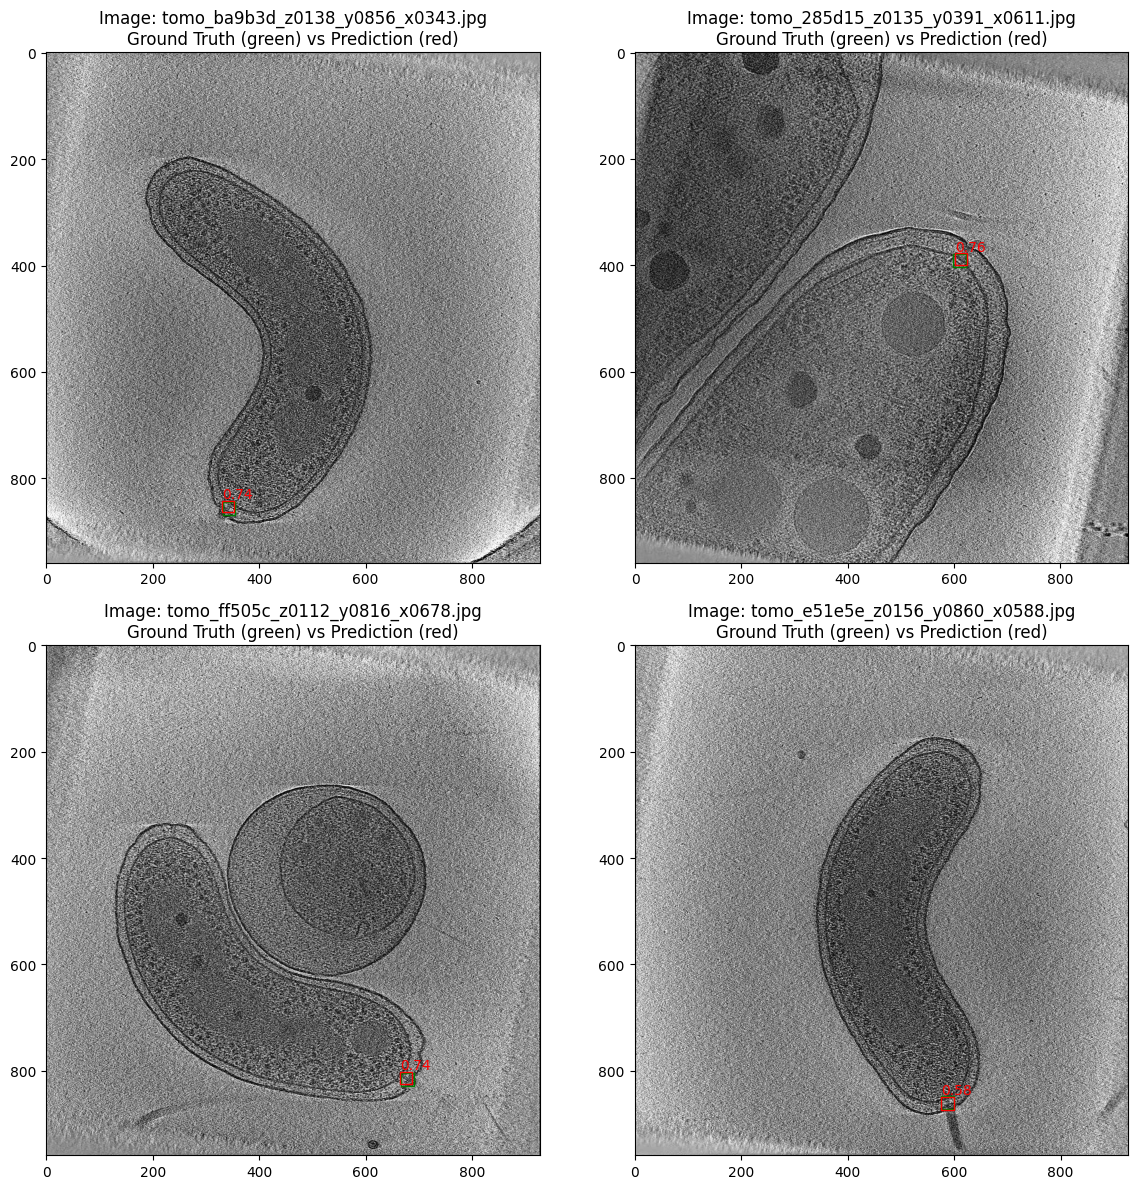

In [ ]:
if __name__ == "__main__":
    main()

# Section 9 -Plot YOLO Training Curves 

In [ ]:
# === Plot all YOLO training curves from results.csv ===
import os
import pandas as pd
import matplotlib.pyplot as plt

RUN_DIR = "/kaggle/working/yolo_weights/motor_detector"
CSV_PATH = os.path.join(RUN_DIR, "results.csv")

assert os.path.exists(CSV_PATH), f"results.csv not found at {CSV_PATH}"
df = pd.read_csv(CSV_PATH)

def find_col(substring):
    """Return the first column that contains the given substring (or None)."""
    for c in df.columns:
        if substring in c:
            return c
    return None

# --- Locate loss columns (robust to Ultralytics naming) ---
cols = {
    "train_box": find_col("train/box"),
    "train_cls": find_col("train/cls"),
    "train_dfl": find_col("train/dfl"),
    "val_box":   find_col("val/box"),
    "val_cls":   find_col("val/cls"),
    "val_dfl":   find_col("val/dfl"),
    "epoch":     "epoch" if "epoch" in df.columns else df.index.name
}

# Safety check
missing = [k for k, v in cols.items() if v is None and k != "epoch"]
if missing:
    print("Warning: missing columns:", missing)

# Choose best epoch by minimal validation DFL if available, else by val_box
if cols["val_dfl"] is not None:
    best_idx = df[cols["val_dfl"]].idxmin()
    best_epoch = int(df.loc[best_idx, "epoch"])
else:
    best_idx = df[cols["val_box"]].idxmin() if cols["val_box"] else df.index.min()
    best_epoch = int(df.loc[best_idx, "epoch"]) if "epoch" in df.columns else int(best_idx)

def save_plot(fig, name):
    out = os.path.join(RUN_DIR, name)
    fig.savefig(out, bbox_inches="tight", dpi=160)
    plt.close(fig)
    print(f"Saved: {out}")

# --- 1) Box loss ---
fig = plt.figure(figsize=(8,5))
if cols["train_box"]: plt.plot(df["epoch"], df[cols["train_box"]], label="train/box_loss")
if cols["val_box"]:   plt.plot(df["epoch"], df[cols["val_box"]],   label="val/box_loss")
plt.axvline(best_epoch, linestyle="--", label=f"best @ epoch {best_epoch}")
plt.xlabel("Epoch"); plt.ylabel("Box loss"); plt.title("Box Loss (train/val)"); plt.legend(); plt.grid(True, ls="--", alpha=0.5)
save_plot(fig, "box_loss.png")

# --- 2) Cls loss ---
fig = plt.figure(figsize=(8,5))
if cols["train_cls"]: plt.plot(df["epoch"], df[cols["train_cls"]], label="train/cls_loss")
if cols["val_cls"]:   plt.plot(df["epoch"], df[cols["val_cls"]],   label="val/cls_loss")
plt.axvline(best_epoch, linestyle="--", label=f"best @ epoch {best_epoch}")
plt.xlabel("Epoch"); plt.ylabel("Cls loss"); plt.title("Classification Loss (train/val)"); plt.legend(); plt.grid(True, ls="--", alpha=0.5)
save_plot(fig, "cls_loss.png")

# --- 3) DFL loss ---
fig = plt.figure(figsize=(8,5))
if cols["train_dfl"]: plt.plot(df["epoch"], df[cols["train_dfl"]], label="train/dfl_loss")
if cols["val_dfl"]:   plt.plot(df["epoch"], df[cols["val_dfl"]],   label="val/dfl_loss")
plt.axvline(best_epoch, linestyle="--", label=f"best @ epoch {best_epoch}")
plt.xlabel("Epoch"); plt.ylabel("DFL loss"); plt.title("DFL Loss (train/val)"); plt.legend(); plt.grid(True, ls="--", alpha=0.5)
save_plot(fig, "dfl_loss.png")

# --- 4) Metrics: Precision / Recall / mAP50 / mAP50-95 ---
# Ultralytics names typically look like: 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)'
prec_col = find_col("metrics/precision")
rec_col  = find_col("metrics/recall")
map50    = find_col("metrics/mAP50")
map95    = find_col("metrics/mAP50-95")

fig = plt.figure(figsize=(9,6))
if prec_col: plt.plot(df["epoch"], df[prec_col], label="Precision")
if rec_col:  plt.plot(df["epoch"], df[rec_col],  label="Recall")
if map50:    plt.plot(df["epoch"], df[map50],    label="mAP@50")
if map95:    plt.plot(df["epoch"], df[map95],    label="mAP@50-95")
plt.axvline(best_epoch, linestyle="--", label=f"best @ epoch {best_epoch}")
plt.xlabel("Epoch"); plt.ylabel("Score"); plt.title("Validation Metrics"); plt.legend(); plt.grid(True, ls="--", alpha=0.5)
save_plot(fig, "val_metrics.png")

print("All plots saved next to weights in:", RUN_DIR)


Saved: /kaggle/working/yolo_weights/motor_detector/box_loss.png
Saved: /kaggle/working/yolo_weights/motor_detector/cls_loss.png
Saved: /kaggle/working/yolo_weights/motor_detector/dfl_loss.png
Saved: /kaggle/working/yolo_weights/motor_detector/val_metrics.png
All plots saved next to weights in: /kaggle/working/yolo_weights/motor_detector


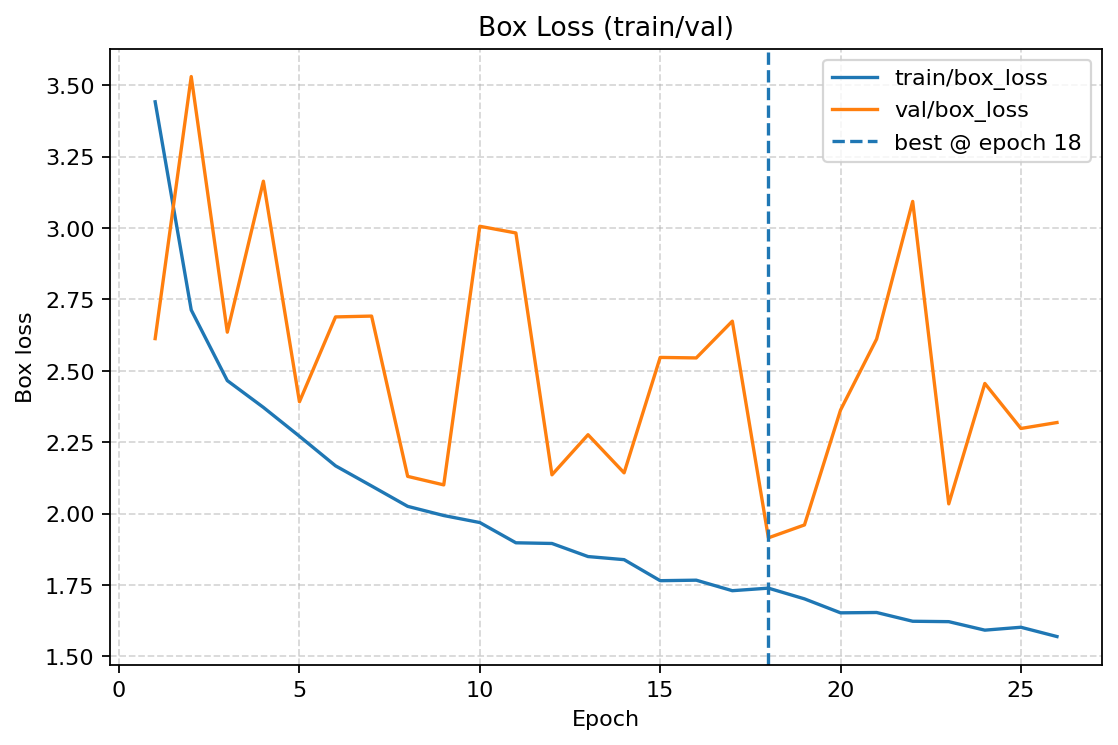

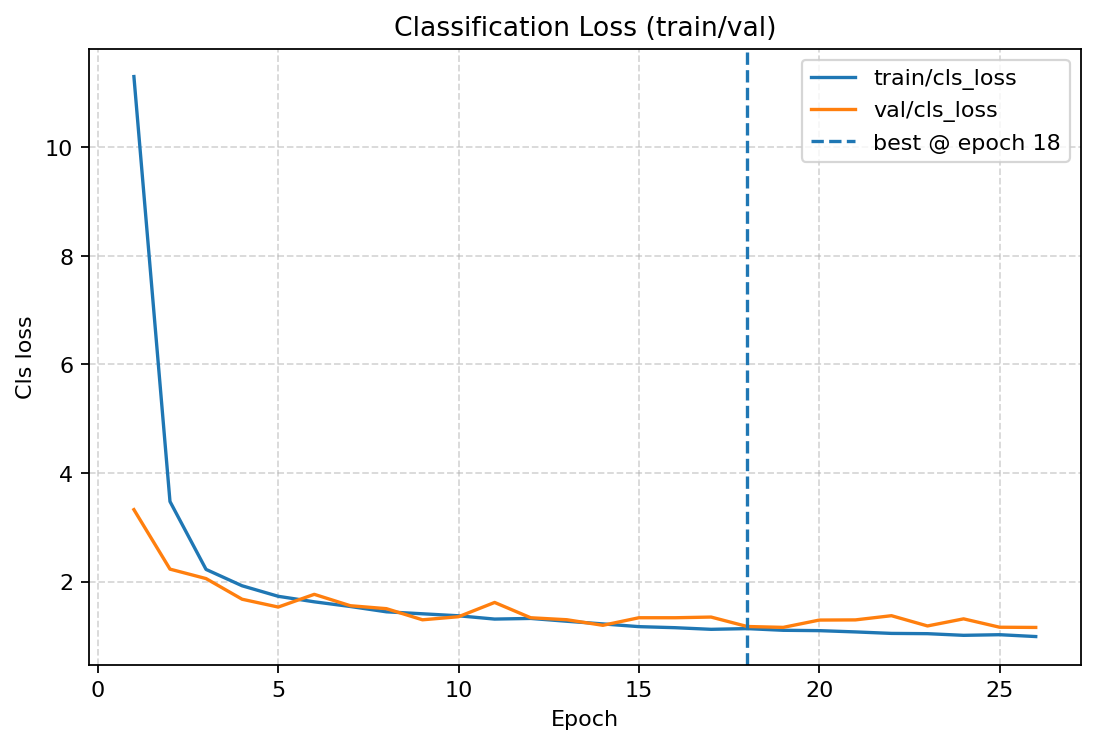

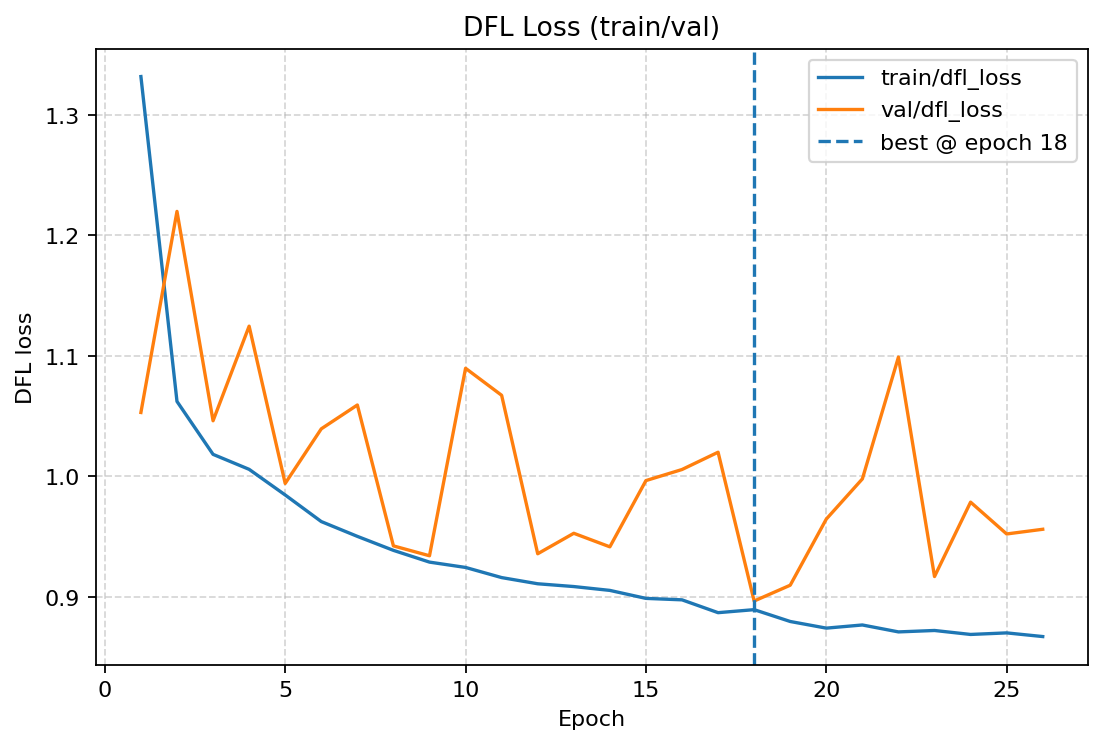

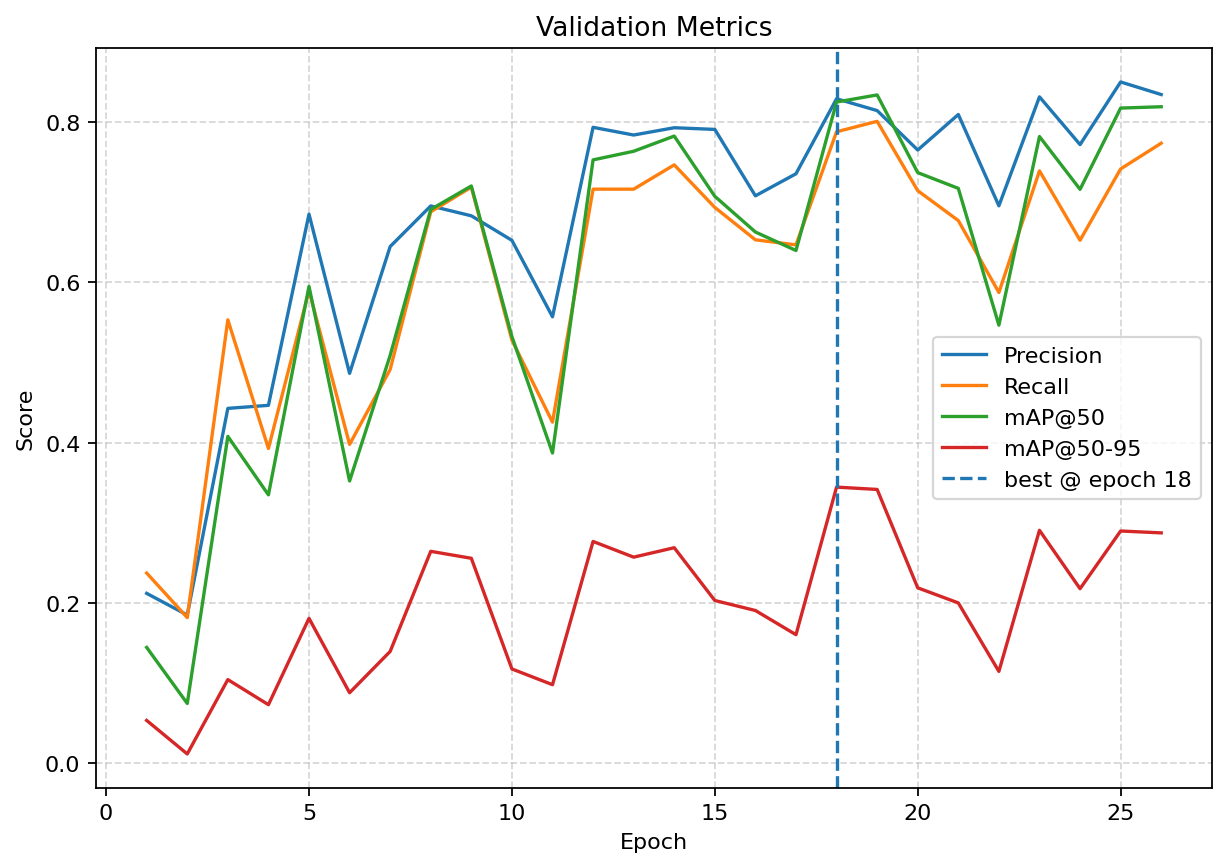

In [ ]:
import os
from IPython.display import Image, display

RUN_DIR = "/kaggle/working/yolo_weights/motor_detector"
plots = ["box_loss.png", "cls_loss.png", "dfl_loss.png", "val_metrics.png"]

for p in plots:
    fp = os.path.join(RUN_DIR, p)
    assert os.path.exists(fp), f"Missing plot: {fp}"
    display(Image(filename=fp))


# SECTION 10 — Save artifacts (weights + results) for reuse


In [ ]:
# === Save artifacts (weights + results) to /kaggle/working ===
import os, shutil, glob

RUN_DIR = "/kaggle/working/yolo_weights/motor_detector"
WEIGHTS_DIR = os.path.join(RUN_DIR, "weights")

os.makedirs("/kaggle/working/artifacts", exist_ok=True)

# Copy best/last weights to working root (easier to reuse / make dataset)
for name in ("best.pt", "last.pt"):
    src = os.path.join(WEIGHTS_DIR, name)
    if os.path.exists(src):
        dst = f"/kaggle/working/{name}"
        shutil.copy2(src, dst)
        print(f"Copied: {src} -> {dst}")
    else:
        print(f"Missing: {src}")

# Also copy results.csv and key plots (optional but useful)
for name in ("results.csv", "labels.jpg", "dfl_loss_curve.png", "box_loss.png", "cls_loss.png", "val_metrics.png"):
    src = os.path.join(RUN_DIR, name)
    if os.path.exists(src):
        dst = f"/kaggle/working/artifacts/{name}"
        shutil.copy2(src, dst)
        print(f"Copied: {src} -> {dst}")

print("\nArtifacts saved under /kaggle/working and /kaggle/working/artifacts")
